First Step on Deep Learning Using Tensorflow
=============


各位同学们，我们在第九课上已经给大家介绍过了基础的深度学习知识。 这种最简单的网络是上一层网络全部链接到下一层网络，所以也称作 fully-connected（全连接） 网络。 

在本次作业中，我们将使用经典数据集 mnist的升级版，notMNIST构建神经网络进行图像分类。 

本次作业，你需要完成1, 2, 3三个联系。 能够掌握：

1. 数据预处理的知识
2. 深度学习程序的构建方式
3. 训练集、测试集、验证集
4. 神经网络的基础知识
5. 图计算网络
6. 正则化

等非常重要的知识 

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://yaroslavvb.com/upload/notMNIST/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

.\notMNIST_large already present - Skipping extraction of .\notMNIST_large.tar.gz.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
.\notMNIST_small already present - Skipping extraction of .\notMNIST_small.tar.gz.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

.\notMNIST_large\A.pickle already present - Skipping pickling.
.\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\D.pickle already present - Skipping pickling.
.\notMNIST_small\E.pickle already present - Skipping pickling.
.\notMNIST_small\F.pickle already present - Skipping pi

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [5]:
def display_sample_image(dataset_list):
    fig = plt.figure(figsize = (10, 10))
    for i in range(len(dataset_list)):
        file = dataset_list[i]
        label = file[-8]
        print('Processing %s'% file)
        with open(file, 'rb') as f:
            dataset = pickle.load(f)
            index = np.random.randint(low=1, high=len(dataset), size=1)
            print('Picked %s image' % index)
            image = dataset[index][0,:,:] # Slice the 3D matrix to get the 2D image matrix
            #print(image.shape)
            ax = fig.add_subplot(2, 5, i+1) # Add subplots to the figure, 2 row * 5 column
            ax.title.set_text(label)
            plt.imshow(image) # Render the image 

Processing .\notMNIST_large\A.pickle
Picked [29753] image
Processing .\notMNIST_large\B.pickle
Picked [17410] image
Processing .\notMNIST_large\C.pickle
Picked [18285] image
Processing .\notMNIST_large\D.pickle
Picked [4661] image
Processing .\notMNIST_large\E.pickle
Picked [13127] image
Processing .\notMNIST_large\F.pickle
Picked [35776] image
Processing .\notMNIST_large\G.pickle
Picked [14926] image
Processing .\notMNIST_large\H.pickle
Picked [21018] image
Processing .\notMNIST_large\I.pickle
Picked [6518] image
Processing .\notMNIST_large\J.pickle
Picked [42863] image


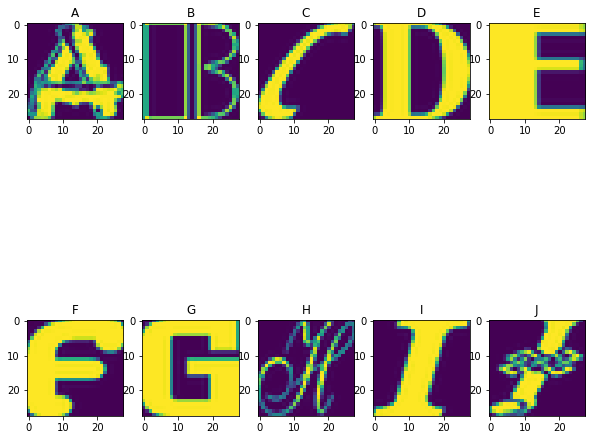

In [10]:
display_sample_image(train_datasets) # Randomly view some train set images

Processing .\notMNIST_small\A.pickle
Picked [58] image
Processing .\notMNIST_small\B.pickle
Picked [1159] image
Processing .\notMNIST_small\C.pickle
Picked [514] image
Processing .\notMNIST_small\D.pickle
Picked [1677] image
Processing .\notMNIST_small\E.pickle
Picked [965] image
Processing .\notMNIST_small\F.pickle
Picked [908] image
Processing .\notMNIST_small\G.pickle
Picked [1361] image
Processing .\notMNIST_small\H.pickle
Picked [740] image
Processing .\notMNIST_small\I.pickle
Picked [800] image
Processing .\notMNIST_small\J.pickle
Picked [1375] image


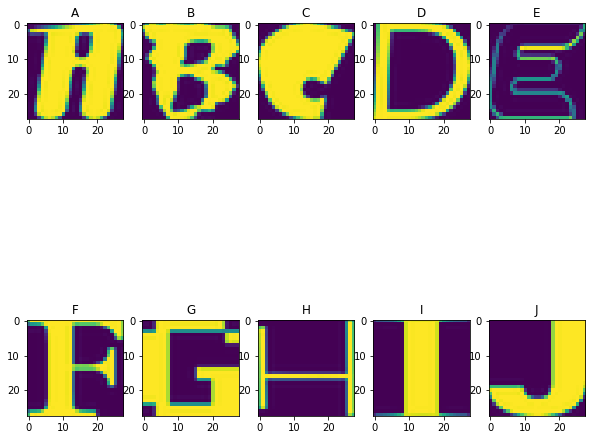

In [114]:
display_sample_image(test_datasets) # Randomly view some test set images

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [6]:
def check_data_size(dataset_list):
    for i in range(len(dataset_list)):
        file = dataset_list[i]
        print('Processing %s'% file)
        with open(file, 'rb') as f:
            dataset = pickle.load(f)
            print(dataset.shape)

In [82]:
check_data_size(train_datasets)

Processing .\notMNIST_large\A.pickle
(52909, 28, 28)
Processing .\notMNIST_large\B.pickle
(52911, 28, 28)
Processing .\notMNIST_large\C.pickle
(52912, 28, 28)
Processing .\notMNIST_large\D.pickle
(52911, 28, 28)
Processing .\notMNIST_large\E.pickle
(52912, 28, 28)
Processing .\notMNIST_large\F.pickle
(52912, 28, 28)
Processing .\notMNIST_large\G.pickle
(52912, 28, 28)
Processing .\notMNIST_large\H.pickle
(52912, 28, 28)
Processing .\notMNIST_large\I.pickle
(52912, 28, 28)
Processing .\notMNIST_large\J.pickle
(52911, 28, 28)


In [83]:
check_data_size(test_datasets)

Processing .\notMNIST_small\A.pickle
(1872, 28, 28)
Processing .\notMNIST_small\B.pickle
(1873, 28, 28)
Processing .\notMNIST_small\C.pickle
(1873, 28, 28)
Processing .\notMNIST_small\D.pickle
(1873, 28, 28)
Processing .\notMNIST_small\E.pickle
(1873, 28, 28)
Processing .\notMNIST_small\F.pickle
(1872, 28, 28)
Processing .\notMNIST_small\G.pickle
(1872, 28, 28)
Processing .\notMNIST_small\H.pickle
(1872, 28, 28)
Processing .\notMNIST_small\I.pickle
(1872, 28, 28)
Processing .\notMNIST_small\J.pickle
(1872, 28, 28)


We can see that the data is well-balanced.

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [7]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        #print(label)
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [8]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [9]:
def display_another_sample_image(dataset, labels):
    fig = plt.figure(figsize = (10, 10))
    for i in range(0, 10):
        index = np.random.randint(low=1, high=len(dataset), size=1)
        print('Picked %s image' % index)
        image = dataset[index][0,:,:] # Slice the 3D matrix to get the 2D image matrix
        ax = fig.add_subplot(2, 5, i+1) # Add subplots to the figure, 2 row * 5 column
        ax.title.set_text(labels[index])
        plt.axis('off')
        plt.imshow(image) # Render the image 

Picked [187607] image
Picked [24312] image
Picked [66884] image
Picked [57709] image
Picked [175401] image
Picked [83315] image
Picked [17575] image
Picked [88727] image
Picked [66819] image
Picked [1803] image


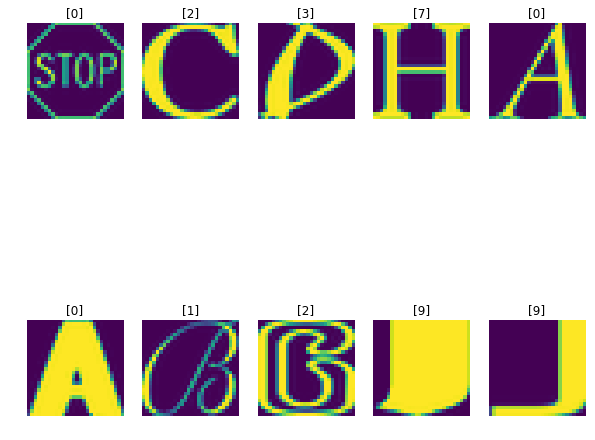

In [83]:
display_another_sample_image(train_dataset, train_labels)

Picked [405] image
Picked [745] image
Picked [9589] image
Picked [6619] image
Picked [9070] image
Picked [1739] image
Picked [7996] image
Picked [8881] image
Picked [8663] image
Picked [8133] image


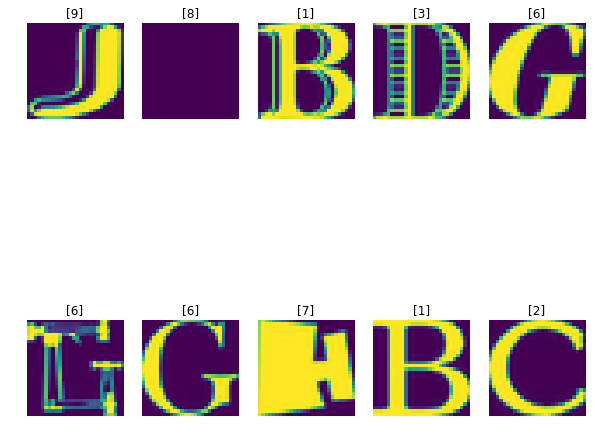

In [84]:
display_another_sample_image(test_dataset, test_labels)

Picked [551] image
Picked [6413] image
Picked [2043] image
Picked [9653] image
Picked [3421] image
Picked [1068] image
Picked [5312] image
Picked [134] image
Picked [4823] image
Picked [7118] image


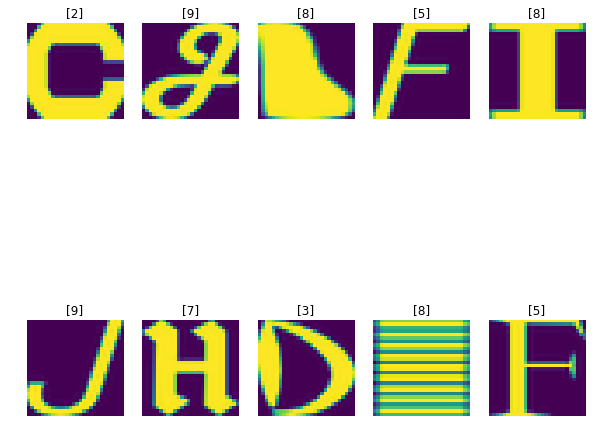

In [85]:
display_another_sample_image(valid_dataset, valid_labels)

It looks that the randomized data still looks good! :)

Finally, let's save the data for later reuse:

In [92]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [93]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [10]:
import hashlib
import random
 
def extract_overlap_hash_where(dataset_1, dataset_2):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = {}
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap[i] = duplicates[0]
    return overlap

def display_overlap_images(overlap, source_dataset, target_dataset):
    overlap = {k: v for k, v in overlap.items() if len(v) >= 3}
    item = random.choice(list(overlap.keys())) # Randomly choose an index in overlap images
    images = np.concatenate(([source_dataset[item]], target_dataset[overlap[item][0:9]])) # Choose the first 10 overlap images from choosen index onwards
    plt.suptitle('images from %s onwards' % item)
    for i, image in enumerate(images):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    
def remove_overlap(dataset_1, dataset_2, label_1):
    dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
    dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
    overlap = list()
    for i, hash1 in enumerate(dataset_hash_1):
        duplicates = np.where(dataset_hash_2 == hash1)
        if len(duplicates[0]):
            overlap.append(i)
    return np.delete(dataset_1, overlap, 0), np.delete(label_1, overlap, None)

In [11]:
overlap1 = extract_overlap_hash_where(train_dataset, test_dataset)
overlap2 = extract_overlap_hash_where(train_dataset, valid_dataset)
overlap3 = extract_overlap_hash_where(test_dataset, valid_dataset)

In [12]:
print('There are %s duplicates between training and test dataset.\nThere are %s duplicates between training and valid dataset. \nThere are %s duplicates between test and valid dataset' % (len(overlap1), len(overlap2), len(overlap3)))

There are 3622 duplicates between training and test dataset.
There are 3627 duplicates between training and valid dataset. 
There are 200 duplicates between test and valid dataset


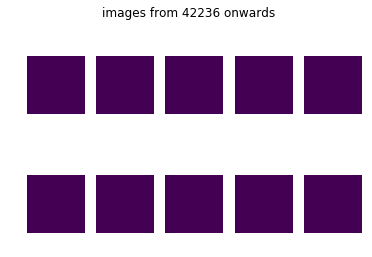

In [98]:
display_overlap_images(overlap1, train_dataset, test_dataset)

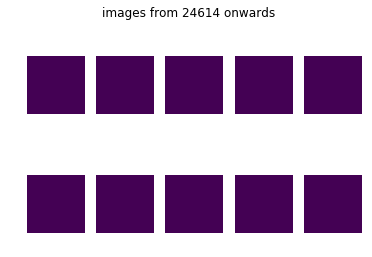

In [99]:
display_overlap_images(overlap2, train_dataset, valid_dataset)

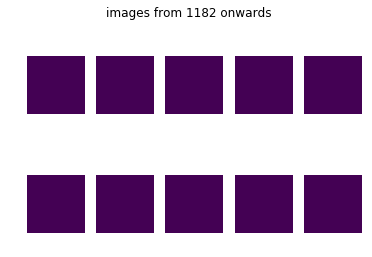

In [100]:
display_overlap_images(overlap3, test_dataset, valid_dataset)

In [13]:
sanitized_train_dataset, sanitized_train_label = remove_overlap(train_dataset, test_dataset, train_labels)
sanitized_test_dataset, sanitized_test_label = remove_overlap(test_dataset, valid_dataset, test_labels)
sanitized_valid_dataset, sanitized_valid_label = remove_overlap(valid_dataset, train_dataset, valid_labels)

In [14]:
print('The sanitized train dataset has %s images\nThe sanitized valid dataset has %s images\nThe sanitized test dataset has %s images' % (len(sanitized_train_dataset), len(valid_dataset), len(sanitized_test_dataset)))

The sanitized train dataset has 196378 images
The sanitized valid dataset has 10000 images
The sanitized test dataset has 9800 images


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

In [39]:
def get_sample_dataset(sample_size):
    # let's shuffle the letters to have random validation and training set
    random_train_dataset, random_train_labels = randomize(sanitized_train_dataset, sanitized_train_label)
    random_test_dataset, random_test_labels = randomize(sanitized_test_dataset, sanitized_test_label)
    random_valid_dataset, random_valid_labels = randomize(sanitized_valid_dataset, sanitized_valid_label)

    sample_train_dataset = random_train_dataset[0:sample_size]
    sample_train_label = random_train_labels[0:sample_size]
    sample_test_dataset = random_test_dataset[0:sample_size]
    sample_test_label = random_test_labels[0:sample_size]
    sample_valid_dataset = random_valid_dataset[0:sample_size]
    sample_valid_label = random_valid_labels[0:sample_size]
    
    return sample_train_dataset, sample_train_label, sample_test_dataset, sample_test_label, sample_valid_dataset, sample_valid_label

In [53]:
def d3_to_d2(d3_dataset):
    nsamples, nx, ny = d3_dataset.shape
    d2_dataset = d3_dataset.reshape((nsamples,nx*ny))
    return d2_dataset

In [86]:
def train_and_score_LR_model(train_dataset, train_label, valid_dataset, valid_label, test_dataset, test_label):
    d2_train_dataset = d3_to_d2(train_dataset)
    d2_valid_dataset = d3_to_d2(valid_dataset)
    d2_test_dataset = d3_to_d2(test_dataset)
    
    LR_model = LogisticRegression(solver = 'saga', max_iter= 1000).fit(d2_train_dataset, train_label) # train LR model
    
    accuracy_train = LR_model.score(d2_train_dataset, train_label) # score the model on train dataset
    print('Accuracy on train dataset: {}'.format(accuracy_train))
    
    accuracy_valid = LR_model.score(d2_valid_dataset, valid_label) # score the model on valid dataset
    print('Accuracy on valid dataset: {}'.format(accuracy_valid))

    accuracy_test = LR_model.score(d2_test_dataset, test_label) # score the model on test dataset
    print('Accuracy on test dataset: {}'.format(accuracy_test))

    return LR_model, accuracy_valid, accuracy_test

### Sample size = 50

In [87]:
sample_train_dataset, sample_train_label, sample_test_dataset, sample_test_label, sample_valid_dataset, sample_valid_label = get_sample_dataset(sample_size = 50)

In [81]:
print('Training:', sample_train_dataset.shape, sample_train_label.shape)
print('Validation:', sample_valid_dataset.shape, sample_valid_label.shape)
print('Testing:', sample_test_dataset.shape, sample_test_label.shape)

Training: (50, 28, 28) (50,)
Validation: (50, 28, 28) (50,)
Testing: (50, 28, 28) (50,)


In [88]:
train_and_score_LR_model(sample_train_dataset, sample_train_label, sample_valid_dataset, sample_valid_label, sample_test_dataset, sample_test_label)

C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on train dataset: 1.0
Accuracy on valid dataset: 0.12
Accuracy on test dataset: 0.04


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False), 0.12, 0.04)

### Sample size = 100

In [89]:
sample_train_dataset, sample_train_label, sample_test_dataset, sample_test_label, sample_valid_dataset, sample_valid_label = get_sample_dataset(sample_size = 100)
train_and_score_LR_model(sample_train_dataset, sample_train_label, sample_valid_dataset, sample_valid_label, sample_test_dataset, sample_test_label)

C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy on train dataset: 1.0
Accuracy on valid dataset: 0.1
Accuracy on test dataset: 0.07


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False), 0.1, 0.07)

When the sample size is 50 or 100, the model cannot converge, due to lack of data.

### Sample size = 1000

In [90]:
sample_train_dataset, sample_train_label, sample_test_dataset, sample_test_label, sample_valid_dataset, sample_valid_label = get_sample_dataset(sample_size = 1000)
train_and_score_LR_model(sample_train_dataset, sample_train_label, sample_valid_dataset, sample_valid_label, sample_test_dataset, sample_test_label)

C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on train dataset: 0.918
Accuracy on valid dataset: 0.111
Accuracy on test dataset: 0.108


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False), 0.111, 0.108)

### Sample size = 5000

In [91]:
sample_train_dataset, sample_train_label, sample_test_dataset, sample_test_label, sample_valid_dataset, sample_valid_label = get_sample_dataset(sample_size = 5000)
train_and_score_LR_model(sample_train_dataset, sample_train_label, sample_valid_dataset, sample_valid_label, sample_test_dataset, sample_test_label)

C:\Users\Zhang Bo Chao\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on train dataset: 0.45
Accuracy on valid dataset: 0.1052
Accuracy on test dataset: 0.1036


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False), 0.1052, 0.1036)

### We can see that when sample size increases, the model accuracy for both valid and test set increases. Since this is a 10-class classification problem, if the model accuracy is lower than 0.1, the model is considered to be equivalent to random guess. 
### The model has high accuracy on training set, low accuracy in both valid and test set. It indicates that the model is overfitting. The reason of overfitting is lack of data.
### When sample size = 5000, the model no longer looks like overfitting. But the accuracy is only 0.1036 on test set, which is pretty low. This is because the data cannot be fitted into simple model like Logistic Regression. We need to try more complex models, such as neural network.